In [14]:
import sys
import os

root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from src.model_numpy import MLP

In [20]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [158]:
df = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")


X = df.drop(columns=["price_class"])
y = df["price_class"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_test_initial = df_test.drop(columns=["price_class"])
y_test_initial = df_test["price_class"]
mask = ~pd.isna(y_test_initial)
#print(mask)
X_test = X_test_initial[mask]
y_test = y_test_initial[mask]

num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X_train.select_dtypes(include=["object"]).columns

num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
X_train[cat_cols] = cat_imputer.fit_transform(X_train[cat_cols])

X_val[num_cols] = num_imputer.transform(X_val[num_cols])
X_val[cat_cols] = cat_imputer.transform(X_val[cat_cols])

X_test[num_cols] = num_imputer.transform(X_test[num_cols])
X_test[cat_cols] = cat_imputer.transform(X_test[cat_cols])

X_train_encoded = pd.get_dummies(X_train, columns=cat_cols, drop_first=False, dtype=int)

X_val_encoded = pd.get_dummies(X_val, columns=cat_cols, drop_first=False, dtype=int)
X_val_encoded = X_val_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

X_test_encoded = pd.get_dummies(X_test, columns=cat_cols, drop_first=False, dtype=int)

X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

scaler = StandardScaler()

X_train_encoded[num_cols] = scaler.fit_transform(X_train_encoded[num_cols])
X_val_encoded[num_cols] = scaler.transform(X_val_encoded[num_cols])
X_test_encoded[num_cols] = scaler.transform(X_test_encoded[num_cols])

X_train_final = X_train_encoded.values
y_train_final = y_train.values

X_val_final = X_val_encoded.values
y_val_final = y_val.values

X_test_final = X_test_encoded.values
y_test_final = y_test.values


C:\Users\HP\AppData\Local\Temp\ipykernel_14392\2972855240.py:20: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = X_train.select_dtypes(include=["object"]).columns


In [159]:
X_train = X_train_final
y_train = y_train_final
X_val = X_val_final
y_val = y_val_final
X_test = X_test_final
y_test = y_test_final

In [129]:
X_test

array([[-0.25237335,  0.24261132,  1.69838973, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.08505237, -0.18885978,  1.79007181, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.46777896, -2.0706976 , -0.52490051, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.08505237, -0.04330326, -0.41029792, ...,  0.        ,
         1.        ,  0.        ],
       [-0.25237335, -1.15577092,  0.7586485 , ...,  0.        ,
         1.        ,  0.        ],
       [-0.3038128 ,  0.82483739, -0.47905947, ...,  1.        ,
         0.        ,  0.        ]], shape=(8270, 12))

In [46]:
X_train[0].size

12

In [35]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [160]:
def train_model(activation, lr=0.01, epochs=200):
    model = MLP(
        layer_sizes=[X_train.shape[1], 64, 32, 4],
        activation=activation
    )

    train_accs = []
    val_accs = []

    grad_l1 = []
    grad_l2 = []

    for epoch in range(epochs):
        probs = model.forward(X_train)

        loss = model.compute_loss(y_train)

        model.backward(y_train)

        grad_l1.append(np.mean(np.abs(model.dW[1])))
        grad_l2.append(np.mean(np.abs(model.dW[2])))

        model.step(lr)

        train_preds = np.argmax(model.x[model.L], axis=1)
        val_probs = model.forward(X_val)
        val_preds = np.argmax(val_probs, axis=1)

        train_accs.append(accuracy(y_train, train_preds))
        val_accs.append(accuracy(y_val, val_preds))

    return model, train_accs, val_accs, grad_l1, grad_l2


In [163]:
sig_model, sig_train, sig_val, sig_g1, sig_g2 = train_model("sigmoid", 0.9, 200)
relu_model, relu_train, relu_val, relu_g1, relu_g2 = train_model("relu", 0.6, 200)

In [154]:
print(relu_train[-1])
print(relu_val[-1])
print(sig_train[-1])
print(sig_val[-1])

0.8329403228732087
0.8258766626360339
0.8143479049519318
0.8008464328899637


In [155]:
def test_model(model, X_test, y_test):
    probs = model.forward(X_test)
    preds = np.argmax(probs, axis=1)
    test_acc = accuracy(y_test, preds)

    print("Test Accuracy:", test_acc)



In [156]:
test_model(sig_model, X_test, y_test)
test_model(relu_model, X_test, y_test)


Test Accuracy: 0.3656297108400713
Test Accuracy: 0.35069206523228724


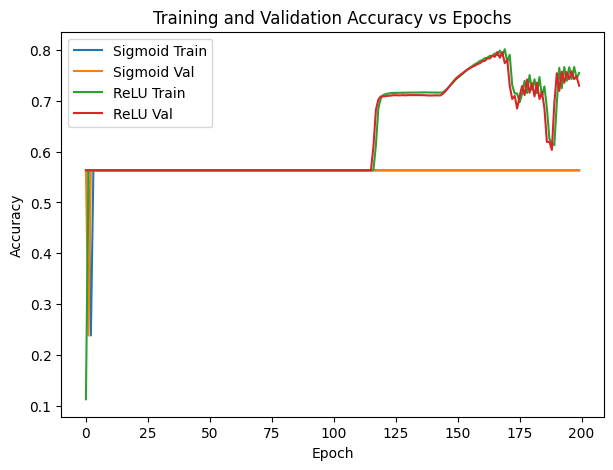

In [164]:
plt.figure(figsize=(7, 5))
plt.plot(sig_train, label="Sigmoid Train")
plt.plot(sig_val, label="Sigmoid Val")
plt.plot(relu_train, label="ReLU Train")
plt.plot(relu_val, label="ReLU Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy vs Epochs")
plt.legend()
plt.show()

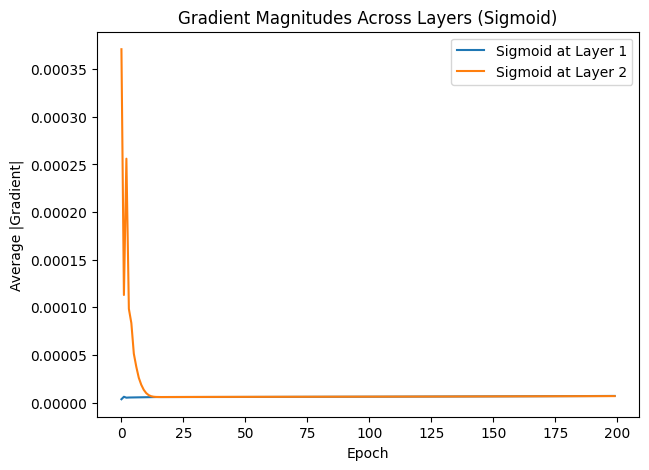

In [64]:
plt.figure(figsize=(7, 5))
plt.plot(sig_g1, label="Sigmoid at Layer 1")
plt.plot(sig_g2, label="Sigmoid at Layer 2")
plt.xlabel("Epoch")
plt.ylabel("Average |Gradient|")
plt.title("Gradient Magnitudes Across Layers (Sigmoid)")
plt.legend()
plt.show()


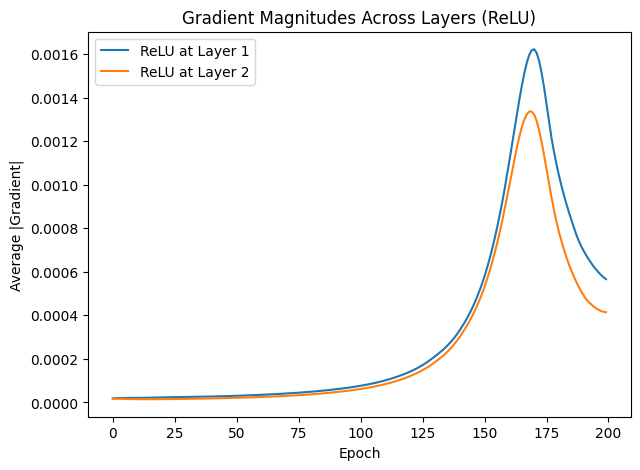

In [65]:
plt.figure(figsize=(7, 5))
plt.plot(relu_g1, label="ReLU at Layer 1")
plt.plot(relu_g2, label="ReLU at Layer 2")
plt.xlabel("Epoch")
plt.ylabel("Average |Gradient|")
plt.title("Gradient Magnitudes Across Layers (ReLU)")
plt.legend()
plt.show()
